# Concrete Strength Prediction using Random Forest

This notebook contains my best approach to building this model

## 1. Importing Required Libraries

I am importing pandas, numpy, matplotlib, seaborn and sklearn libraries for data manipulation, visualization, and machine learning

In [1]:
# importing required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings('ignore')

# setting style for plots
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load the Dataset

Using pandas to load the training and test datasets from CSV files.

In [2]:
# load the datasets
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
sample_submission = pd.read_csv('datasets/sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission selection shape: {sample_submission.shape}")

# Display first few rows of training data
print("\nFirst 5 rows of training data:")
train_df.head()

Training data shape: (5407, 10)
Test data shape: (3605, 9)
Sample submission selection shape: (3605, 2)

First 5 rows of training data:


,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


## 3. Data Preprocessing

Handling missiong values, encoding categorical variables, and prepraring features for the models

In [3]:
# Checking for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

# Since, there are no missing values, we will proceed with feature selection
# Prepraring features and target
X = train_df.drop(['id', 'Strength'], axis=1)
y = train_df['Strength']
X_test = test_df.drop(['id'], axis=1)

print(f"\nFeature matric shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

print("\nFeature Columns:")
print(X.columns.tolist())

Missing values in training data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64

Missing values in test data:
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64

Feature matric shape: (5407, 8)
Target vector shape: (5407,)
Test feature matrix shape: (3605, 8)

Feature Columns:
['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


In [4]:
# Random Forest does not require feature scaling, but we will keep the option
# For Random Forest, we will use the original features without scaling
print("Random Forest can work with original features without scaling.")
print('using original features for Random Forest model.')

# Keeping the original features for Random Forest
X_final = X.copy()
X_test_final = X_test.copy()

print(f"\nTraining features shape: {X_final.shape}")
print(f"Test feature shape: {X_test.shape}")

# Display first few rows of features
print('\nFirst 5 rows of features:')
X_final.head()

Random Forest can work with original features without scaling.
using original features for Random Forest model.

Training features shape: (5407, 8)
Test feature shape: (3605, 8)

First 5 rows of features:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90


## 4. Feature Engineering

In [5]:
# Creating feature engineeing for both train and sets
print("Starting feature engineering...")
print(f"Original feature columns: {X.columns.tolist()}")

Starting feature engineering...
Original feature columns: ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


### Creating some engineered features for the training data

In [6]:
# Creating engineered features for training data
X_engineered = X.copy()

# Ratio features
X_engineered['CementToWater'] = X['CementComponent'] / (X['WaterComponent'] + 1e-8)
X_engineered['CementToAge'] = X['CementComponent'] / (X['AgeInDays'] + 1)
X_engineered['TotalBinder'] = X['CementComponent'] + X['BlastFurnaceSlag'] + X['FlyAshComponent']
X_engineered['WaterToBinder'] = X['WaterComponent'] / (X_engineered['TotalBinder'] + 1e-8)

# Polynomial features for key components
poly = PolynomialFeatures(degree=2, include_bias=False)
key_features = ['CementComponent', 'WaterComponent', 'AgeInDays']
poly_features = poly.fit_transform(X[key_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(key_features))

# Removing duplicae columns (keeping only interaction terms and squared terms, not original features)
# Original features are already in X_engineered
poly_interaction_cols = [col for col in poly_df.columns if col not in key_features]
poly_df_filtered = poly_df[poly_interaction_cols]
X_engineered = pd.concat([X_engineered, poly_df_filtered], axis=1)


### Doing the same for the test data

In [7]:
# Apply same feature engineering to test data
X_test_engineered = X_test.copy()
X_test_engineered['CementToWater'] = X_test['CementComponent'] / (X_test['WaterComponent'] + 1e-8)
X_test_engineered['CementToAge'] = X_test['CementComponent'] / (X_test['AgeInDays'] + 1)
X_test_engineered['TotalBinder'] = X_test['CementComponent'] + X_test['BlastFurnaceSlag'] + X_test['FlyAshComponent']
X_test_engineered['WaterToBinder'] = X_test['WaterComponent'] / (X_test_engineered['TotalBinder'] + 1e-8)

# Apply polynomial features to test data
poly_features_test = poly.transform(X_test[key_features])
poly_df_test = pd.DataFrame(poly_features_test, columns=poly.get_feature_names_out(key_features))

# Removing duplicate columns for test data too
poly_df_test_filtered = poly_df_test[poly_interaction_cols]
X_test_engineered = pd.concat([X_test_engineered, poly_df_test_filtered], axis=1)

print(f"Engineered training features hspae: {X_engineered.shape}")
print(f"Engineered test features shape: {X_test_engineered.shape}")
print(f"New feature columns added: {[col for col in X_engineered.columns if col not in X.columns]}")

Engineered training features hspae: (5407, 18)
Engineered test features shape: (3605, 18)
New feature columns added: ['CementToWater', 'CementToAge', 'TotalBinder', 'WaterToBinder', 'CementComponent^2', 'CementComponent WaterComponent', 'CementComponent AgeInDays', 'WaterComponent^2', 'WaterComponent AgeInDays', 'AgeInDays^2']


## 5. Splitting the data into Train and Test Sets

Separating features and target variables, and split the training data for model validation

In [8]:
# Updating X_final and X_test_final to use engineered features
X_final = X_engineered.copy()
X_test_final = X_test_engineered.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

print(f"\ntraining set percentage: {len(X_train) / len(X_final) * 100:.2f}%")
print(f"Validation set percentage: {len(X_val) / len(X_final) * 100:.2f}%")

Training set shape: (4325, 18)
Validation set shape: (1082, 18)
Training target shape: (4325,)
Validation target shape: (1082,)

training set percentage: 79.99%
Validation set percentage: 20.01%


## 6. Training the Random Forest Model

Creating and training a Random Forest model using sklearn, and evaluating its performance on validation data

Slighlty complex Random Forest Model, using randomized search cv for selecting the best possible parameters

In [11]:
# defining parameter grid for Random Forest
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False]
}

# Using RandomizedSearchCV for efficiency
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

XGBoost model

In [10]:
#XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

Training the models

In [12]:
# Fitting the RandomizedSearchCV to find the best parameters
print("Training the RF model with RandomizedSearchCV for finding the best parameters....")
rf_random.fit(X_train, y_train)

Training the RF model with RandomizedSearchCV for finding the best parameters....


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [13]:
print("Training XGBoost model....")
xgb_model.fit(X_train, y_train)

Training XGBoost model....


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# Voting ensemble
ensemble_model = VotingRegressor([
    ('rf', rf_random.best_estimator_),
    ('xgb', xgb_model)
])

# Training the ensemble
print("Training ensemble model....")
ensemble_model.fit(X_train, y_train)

Training ensemble model....


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=10,
                                                   max_features=0.8,
                                                   min_samples_leaf=4,
                                                   min_samples_split=5,
                                                   n_estimators=300, n_jobs=-1,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_cate...
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=6,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None, ...))])

In [15]:
print("Ensemble model trained successfully!")
print(f"\nRandom Forest best parameters: {rf_random.best_params_}")
print(f"Random Forest CV score: {-rf_random.best_score_:.4f}")
print(f"Number of trees in RF: {rf_random.best_estimator_.n_estimators}")

print(f"\nXGBoost parameters: {xgb_model.get_params()}")

Ensemble model trained successfully!

Random Forest best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 10, 'bootstrap': True}
Random Forest CV score: 153.9870
Number of trees in RF: 300

XGBoost parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'ran

In [ ]:
# Strategy 1: Test baseline model with original featiures only (no feature engineering)
print("=== TESTING BASELINE MODEL (Original Features Only)")

# Using original features without any engineering
X_original = X.copy() # Original 8 features
X_test_original = X_test.copy()

# Split for validation
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_original, y, test_size=0.2, random_state=42
)

# Train baseline Random Fores with hyperparameter optimization

In [17]:
# Making predictions with all models
y_val_pred_ensemble = ensemble_model.predict(X_val)
y_val_pred_random_rf = rf_random.best_estimator_.predict(X_val)
y_val_pred_xgb = xgb_model.predict(X_val)

# Calculating metrics for ensemble
mse_ensemble = mean_squared_error(y_val, y_val_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_val, y_val_pred_ensemble)
r2_ensemble = r2_score(y_val, y_val_pred_ensemble)

# Calculating metrics for randomised rf model
mse_random_rf = mean_squared_error(y_val, y_val_pred_random_rf)
rmse_random_rf = np.sqrt(mse_random_rf)
r2_random_rf = r2_score(y_val, y_val_pred_random_rf)

# Calculating metrics for XGB model
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_sgb = r2_score(y_val, y_val_pred_xgb)

print(f"\n=== MODEL COMPARISON ===")
print(f"Random Forest RMSE: {rmse_random_rf:.4f}, R²: {r2_random_rf:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}, R²: {r2_sgb:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}, R²: {r2_ensemble:.4f}")

print('\nEnsemble Model Performance on Validation set:')
print(f"Mean Squared Error (MSE): {mse_ensemble:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ensemble:.4f}")
print(f"R² Score: {r2_ensemble:.4f}")


=== MODEL COMPARISON ===
Random Forest RMSE: 11.8429, R²: 0.4846
XGBoost RMSE: 12.5096, R²: 0.4249
Ensemble RMSE: 12.0707, R²: 0.4646

Ensemble Model Performance on Validation set:
Mean Squared Error (MSE): 145.7027
Root Mean Squared Error (RMSE): 12.0707
Mean Absolute Error (MAE): 9.4525
R² Score: 0.4646


Feature Importance (Random Forest):
                           Feature  Importance
14       CementComponent AgeInDays    0.310471
16        WaterComponent AgeInDays    0.261303
4        SuperplasticizerComponent    0.055276
11                   WaterToBinder    0.054511
17                     AgeInDays^2    0.046425
7                        AgeInDays    0.038657
5         CoarseAggregateComponent    0.035729
6           FineAggregateComponent    0.034125
10                     TotalBinder    0.026421
8                    CementToWater    0.021955
13  CementComponent WaterComponent    0.021252
9                      CementToAge    0.021251
1                 BlastFurnaceSlag    0.015524
15                WaterComponent^2    0.015475
3                   WaterComponent    0.015072
2                  FlyAshComponent    0.011774
12               CementComponent^2    0.007519
0                  CementComponent    0.007262


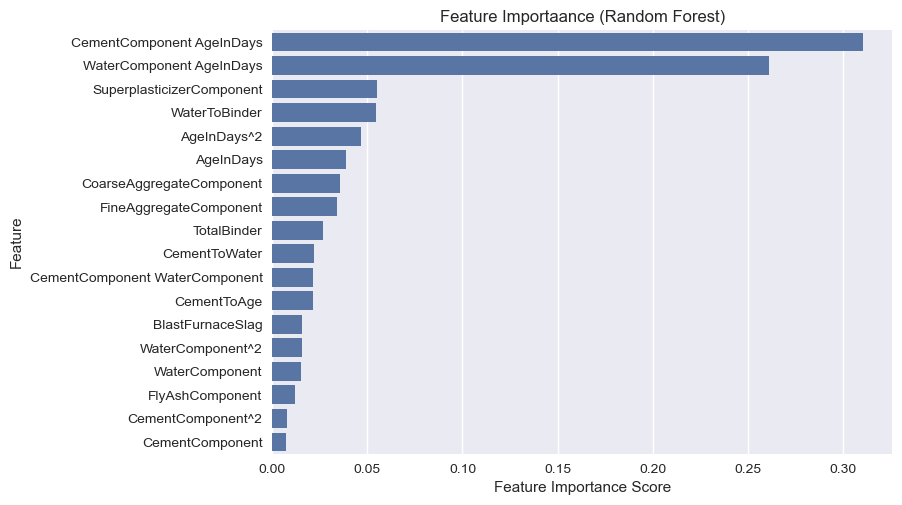


Top 5 most importance features:
CementComponent AgeInDays: 0.3105
WaterComponent AgeInDays: 0.2613
SuperplasticizerComponent: 0.0553
WaterToBinder: 0.0545
AgeInDays^2: 0.0464

Random Forest Model Details:
Number of features used: 18
Out-of-bag score: Not Available (oob_score=fals)


In [19]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': rf_random.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.Figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importaance (Random Forest)')
plt.xlabel('Feature Importance Score')
plt.show()

# Show top 5 most important features
print(f"\nTop 5 most importance features:")
for i, row in feature_importance.head().iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Additional Random Forest specific metrics
print(f"\nRandom Forest Model Details:")
print(f"Number of features used: {rf_random.best_estimator_.n_features_in_}")
print(f"Out-of-bag score: {rf_random.best_estimator_.oob_score_ if hasattr(rf_random.best_estimator_, 'oob_score_') else 'Not Available (oob_score=fals)'}")

Random Forest Model Analysis:
Number of trees: 300
Average tree depth (sample of 10 trees): 10.00
Max tree depth (sample): 10
Min tree depth (sample): 10


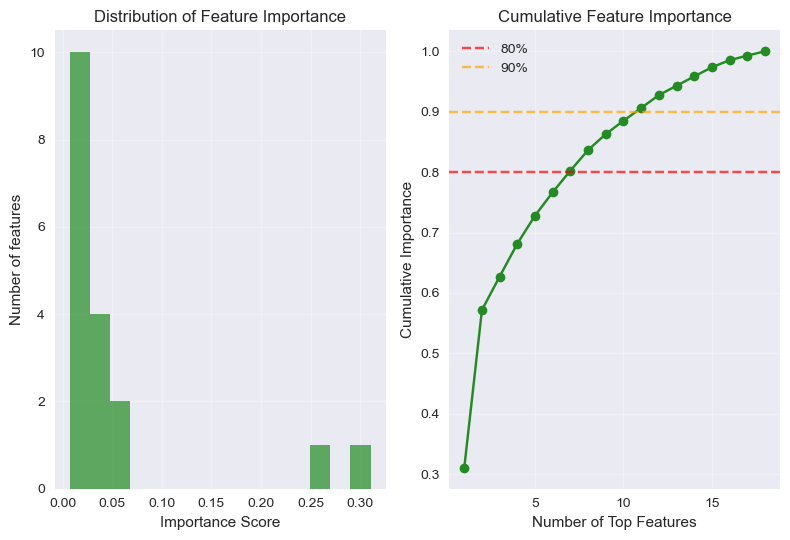


Features contributing to 80% of importance: 7
Features contributing to 90% of importance: 11


In [20]:
# Random Forest specific analysis
print("Random Forest Model Analysis:")
print(f"Number of trees: {rf_random.best_estimator_.n_estimators}")

# Get tree depths (sample from first few trees)
tree_depths = []
for i in range(min(10, rf_random.best_estimator_.n_estimators)) :
    tree_depths.append(rf_random.best_estimator_.estimators_[i].tree_.max_depth)

print(f"Average tree depth (sample of 10 trees): {np.mean(tree_depths):.2f}")
print(f"Max tree depth (sample): {max(tree_depths)}")
print(f"Min tree depth (sample): {min(tree_depths)}")

# Feature importance distribution
plt.Figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(rf_random.best_estimator_.feature_importances_, bins=15, alpha=0.7, color='forestgreen')
plt.title('Distribution of Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Number of features')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumulative_importance = np.cumsum(feature_importance['Importance'].values)
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-', color='forestgreen')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance')
plt.grid(True, alpha=0.3)

# Add horizontal lines for reference
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80%')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
plt.legend()

plt.tight_layout()
plt.show()

# Find how many features contribute to 80% and 90% of importance
feature_80 = np.argmax(cumulative_importance >= 0.8) + 1
feature_90 = np.argmax(cumulative_importance >= 0.9) + 1
print(f"\nFeatures contributing to 80% of importance: {feature_80}")
print(f"Features contributing to 90% of importance: {feature_90}")